# Experiment 01: Baseline Strategies

## Objective
This notebook establishes the **performance benchmark** for standard fluid injection strategies. Before attempting complex AI optimization or parametric waveforms, we must quantify the performance of the "Industry Standard" approach: **Constant Pressure Injection**.

## The Physics of the Baseline
In a Constant Pressure scenario:
1.  **Input:** We maintain a fixed pressure head ($P_{inlet}$) at the boundary.
2.  **Dynamics:** The flow rate is dictated purely by the rock's permeability and the fluid's viscosity (Darcy's Law). As CO2 (non-wetting) displaces Brine (wetting), capillary resistance changes.
3.  **Failure Mode:** We expect this strategy to suffer from **viscous fingering** or **capillary channeling**, where the fluid finds the path of least resistance and leaves large areas of the rock unswept.

**Consistency Check:** This notebook relies on the centralized `physics.py` engine to ensure the rock geometry and fluid properties are identical to the AI experiments.

In [6]:
import jax
import jax.numpy as jnp
from jax import lax
import numpy as np
import matplotlib.pyplot as plt
import physics  # The local immutable physics engine

# 1. Configuration
jax.config.update("jax_enable_x64", True)
physics.ensure_results_dir()

print("Baseline Environment Loaded.")
print(f"Simulation Grid: {physics.NX}x{physics.NY}")

Baseline Environment Loaded.
Simulation Grid: 100x50


## 1. Initialization
We generate the standard testing environment. 
**Crucial:** We use a fixed random seed (`42`) to ensure the rock geometry (porous media mask) is **identical** across all notebooks (`01`, `02`, and `03`). If the rock changes, the comparison is invalid.

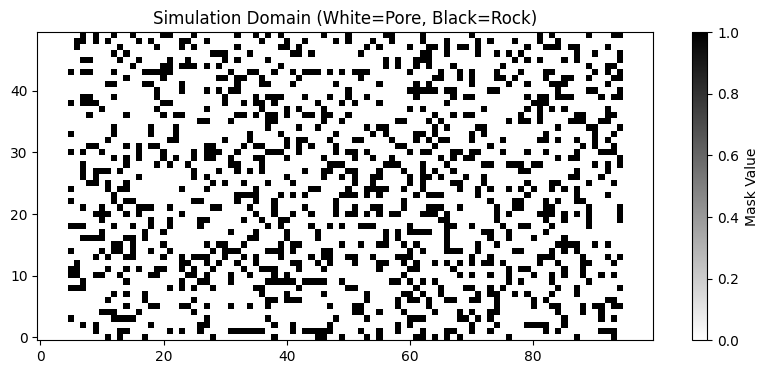

In [7]:
# --- SETUP INITIAL STATE ---

# 1. Define the Rock Geometry (Fixed Seed)
key = jax.random.PRNGKey(42)
mask_init = jax.random.bernoulli(key, p=0.25, shape=(physics.NX, physics.NY)).astype(jnp.float64)

# 2. Clear Inlet/Outlet Zones (Ensure flow is possible)
# We remove rock from the first 5 and last 5 columns
mask_init = mask_init.at[0:5, :].set(0.0).at[-5:, :].set(0.0)

# 3. Initial Fluid State (Resting Brine)
rho_init = jnp.ones((physics.NX, physics.NY)) * physics.RHO_BRINE
u_init = jnp.zeros((physics.NX, physics.NY))

# 4. Calculate Equilibrium Distribution (LBM f_init)
f_init = physics.get_equilibrium(rho_init, u_init, u_init)

# 5. Initial Salt Concentration (50% Saturation)
salt_init = jnp.ones((physics.NX, physics.NY)) * 0.5

# Pack into a tuple for the JAX scanner
state_init = (f_init, salt_init, mask_init)

# Visualization of the Domain
plt.figure(figsize=(10, 4))
plt.imshow(mask_init.T, cmap='gray_r', origin='lower')
plt.title("Simulation Domain (White=Pore, Black=Rock)")
plt.colorbar(label="Mask Value")
plt.show()

## 2. Simulation: Constant Pressure
We simulate 1000 time steps. 
The pressure schedule $P(t)$ is simply a flat line: $P(t) = 0.03$.

We track:
1.  **Saturation ($S_{CO2}$):** What percentage of the pore space is filled with CO2?
2.  **Flux:** How fast is fluid moving through the system?

In [8]:
# --- CONFIGURATION ---
TIME_STEPS = 3000
P_BASELINE = 0.03  # The constant pressure value

# Create the Schedule
p_schedule = jnp.ones(TIME_STEPS) * P_BASELINE

print(f"Starting Simulation: {TIME_STEPS} steps at P={P_BASELINE}...")

# --- RUN SIMULATION (JAX SCANNED) ---
final_state, (hist_sat, hist_flux) = lax.scan(
    physics.lbm_step_pressure, 
    state_init, 
    p_schedule
)

# Unpack final state for plotting
f_final, salt_final, mask_final = final_state
rho_final = jnp.sum(f_final, axis=-1)

print("Simulation Complete.")
print(f"Final Saturation: {hist_sat[-1]:.4f}")

Starting Simulation: 3000 steps at P=0.03...
Simulation Complete.
Final Saturation: 1.0000


## 3. Analysis & Visualization
We visualize the final fluid distribution to understand *why* the baseline performed the way it did. Look for "fingers" of red (CO2) bypassing blue (Brine).

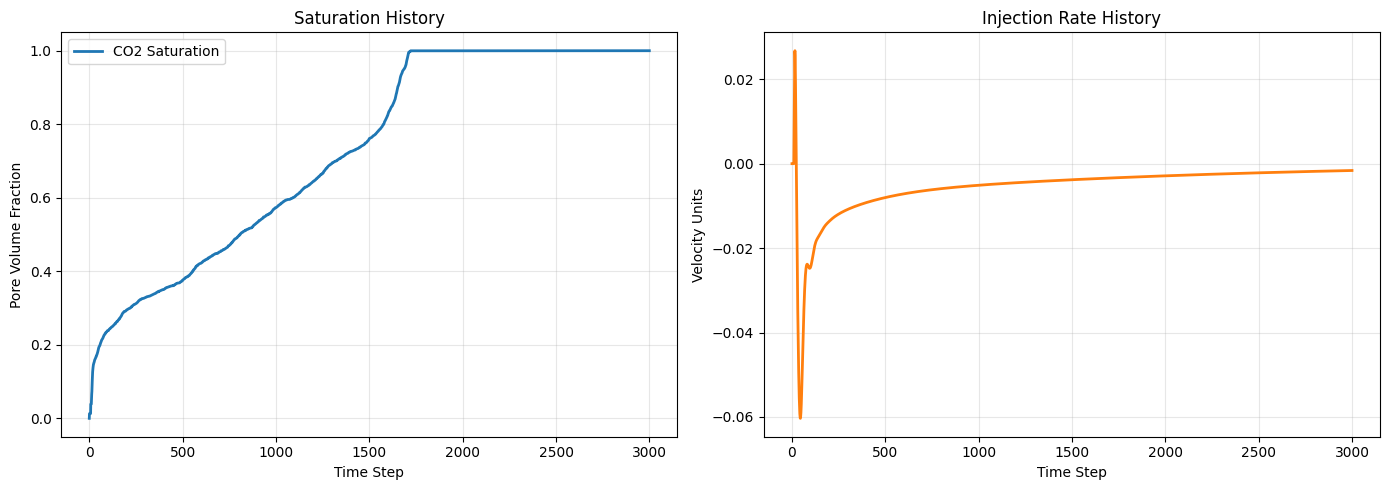

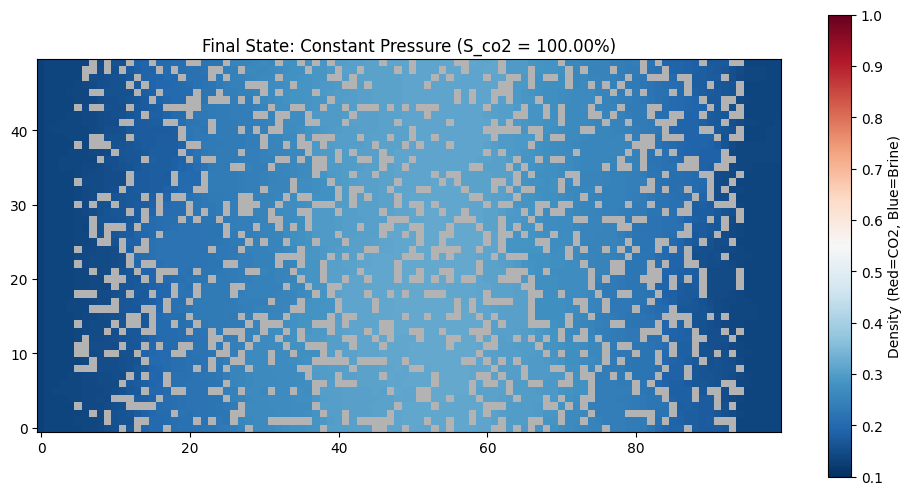

In [9]:
# Convert JAX arrays to Numpy for Plotting
sat_data = np.array(hist_sat)
flux_data = np.array(hist_flux)
rho_viz = np.array(rho_final)
mask_viz = np.array(mask_final)

# --- PLOT 1: Performance Metrics ---
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Saturation Curve
ax[0].plot(sat_data, label="CO2 Saturation", color='tab:blue', linewidth=2)
ax[0].set_title("Saturation History")
ax[0].set_xlabel("Time Step")
ax[0].set_ylabel("Pore Volume Fraction")
ax[0].grid(True, alpha=0.3)
ax[0].legend()

# Flux/Rate Curve
ax[1].plot(flux_data, label="Inlet Flux", color='tab:orange', linewidth=2)
ax[1].set_title("Injection Rate History")
ax[1].set_xlabel("Time Step")
ax[1].set_ylabel("Velocity Units")
ax[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# --- PLOT 2: Final Fluid State ---
plt.figure(figsize=(12, 6))

# Mask out rock for cleaner visualization
rho_masked = np.ma.masked_where(mask_viz > 0.5, rho_viz)

plt.imshow(mask_viz.T, cmap='gray_r', origin='lower', alpha=0.3)
im = plt.imshow(rho_masked.T, cmap='RdBu_r', origin='lower', 
                vmin=physics.RHO_CO2_INIT, vmax=physics.RHO_BRINE)

cbar = plt.colorbar(im, label="Density (Red=CO2, Blue=Brine)")
plt.title(f"Final State: Constant Pressure (S_co2 = {sat_data[-1]:.2%})")
plt.show()

## 4. Data Export
We save the results to the `results/` directory. These files will be loaded by `Final_Analysis.ipynb` to compare against the Waveform and AI strategies.

**Files Saved:** `results/01_baseline.npz`

In [10]:
# Export Data
np.savez("results/01_baseline.npz", 
         saturation=sat_data,
         flux=flux_data,
         pressure_val=P_BASELINE,
         pressure_schedule=np.array(p_schedule))

print("SUCCESS: Baseline data exported to 'results/01_baseline.npz'.")
print("You may now proceed to '02_Waveform_Optimization.ipynb'.")

SUCCESS: Baseline data exported to 'results/01_baseline.npz'.
You may now proceed to '02_Waveform_Optimization.ipynb'.
